## **What comes next?: Using Bayesian Inference to Model Human Musical Expectation**

"*We experience musical motions metaphorically in terms of our experience of physical motions.*" - Steve Larson, 2004

### **Introduction**
When you listen to a song you have never heard before, does it feel like you can predict the notes before they occur? What if I played you five notes on the piano, could you predict the sixth? 

Melodic expectation is a fundamental concept of musical cognition, referring to the cognitive processes involved when one is tasked with predicting the next notes in a melody. An account of melodic expectation explores the idea of “musical forces'', which include gravity, magnetism, and inertia. These forces metaphorically reflect our “experience of physical motions''  (Larson, 2004, p. 458).

**Gravity**: the tendency of an unstable note to descend

**Magetism**: the tendency of an unstable note to move to the nearest stable pitch, a tendency that grows stronger the closer we get to a goal

**Inertia**: the tendency of a pattern of musical motion to continue in the same fashion

We propose a model of melodic expectation that combines both Temperly’s work on probabilistic inference of melodic structure and Larson’s work on musical forces using a Julia and Gen.jl, a probabilistic programming package. To solve this inference problem, we must create a generative model that solves a sequence of inference problems where the output of one is the input of another. The nature of this inference problem invites the utilization of a sequential Monte Carlo method called particle filtering. After a generative process is established, the model will be constrained on real-world data and the output will be compared to human performance in melodic expectation tasks. 

### **Background**

#### **Calculating Musical Forces**
Listeners (but not necessarily players) of music systematically expect completions of musical phrases where the aforementioned musical forces dictate the "auralized traces" (p. 459). In other words, we expect melodies to be completed *and* we expect gravity, magnetism, and intertia to be at play in these completions.

However, the musical forces are not always interpreted in a consistent manner and are often context-dependent. Sometimes, the forces may agree on what the next note should be. Other times, each individual force may produce a different subsequent note. As such, Steve Larson, a melodic expectation researcher, created an algorithm to represent the interactions of these forces:

$F = w_gG + w_mM + w_iI$

where $G$, $M$, and $I$ are scores given to a certain pattern to denote whether it gives into the specific force and $w_g$, $w_m$, and $w_I$ the weights by which the three forces influence the cumulative effect, $F$ (pp. 462-465). 

$G$ is $1$ for patterns that give into gravity and $0$ otherwise.

$M$ is represented by taking the inverse square of the distance in semitones to the a specific goal and subtracting the inverse square of the distance in semitones to the closest stable pitch in the other direction: $\frac{1}{d_{\text{to}}}^2 - \frac{1}{d_{\text{from}}}^2$

$I$ is $1$ for patterns that give into intertia, $-1$ for ones that go against it, and $0$ otherwise.

#### **Probabilistic Model**
Taking a step back from the relationship between individual notes in a melody, David Temperley, a music theory professor, created a probabilistic model of melody perception using Bayesian inference. The objective of his model was to 1) identify keys of melodies, 2) judge the probability of different notes given the prior context, and 3) identify incorrect notes (Temperley, 2008).

More generally, the model infers the most probable underlying structure (meter and key) of a melody given the perception  of the surface (pitches, error-detection, and expectation):

$P(structure|surface) = \frac{P(structure|surface)P(structure)}{P(surface)}$

Since we are only interested in maximizing the right-hand side of the equation, we can rewrite it as this:

$P(structure|surface) \propto P(structure|surface)P(structure)$

And simplify the right side further (p. 420):

$P(structure|surface) \propto P(structure, surface)$

Researching musical cognition is strikingly similar to cognitive linguistics. As such, using a Bayesian approach to this aspect of musical cognition is appropriate because it is similar to other applications of statistical learning such as speech recognition and sentence processing (p. 421).

The following model combines Larson's work on musical forces and Temperley's work on melody perception to reflect human performance in predictive musical tasks.

### **Model Building**

#### **Technical assumptions**
- Pitches will be encoded using the MIDI note value system where C4 (middle C) = 60 and each semitone up or down from C4 is +1 or -1.
- We will only be dealing with major scales.

In [1]:
# Import dependecies
import Pkg
Pkg.activate("psyc261")
Pkg.add(["CSV", "DataFrames"])
Pkg.add("Distributions")
Pkg.add("HypothesisTests")
Pkg.add("GLM")
using Gen
using Plots
using CSV
using DataFrames
using Distributions
using Statistics
using HypothesisTests
using Random
using GLM
include("utils/draw.jl")
;

  Activating project at `~/Algorithms-of-the-Mind/finalproj/psyc261`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`


First, we must define some structs and functions that will help with working with musical notes.

The struct represents a key and the notes in the scale of that key. 

The first helper function that creates a named scale from a root note (starting note) and specified intervals. I did this so I could create different types of scales with one function (major, minor, blues, etc.) Then, I create `notes()`, which returns the pitches of a scale as a vector from the name of the scale, and `create_major_scale()`, which creates a 2-octave scale from a root note and set intervals. I also create `findnearest()`, which finds the nearest stable note in a key to the inputted note. Lastly, I create some major scales to work with later on.

In [2]:
struct MusicalScale
    name::Symbol
    notes::Vector{Int}
end

function create_scale(name::Symbol, root_note::Int, intervals::Vector{Int})
    notes = Int[]
    note = root_note

    for interval in intervals
        note = root_note + interval
        push!(notes, note)
    end

    return MusicalScale(name, notes)
end

function notes(scale::MusicalScale)
    return scale.notes
end

# This function creates a major scale using the specific intervals in all major scales
function create_major_scale(root_note::Int)
    return create_scale(Symbol("major"), root_note, [0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19, 21, 23, 24])
end

# This function finds the degree of a note in a scale if it exists, and the nearest stable note if not
function findnearest(value, array, exclude=nothing)
    filtered_array = isnothing(exclude) ? array : filter(x -> x != exclude, array)
    idx = argmin(abs.(value .- filtered_array))
    return filtered_array[idx]
end

# I create some major scales for the model to draw from later on
C = create_major_scale(60)
G = create_major_scale(55)  
D = create_major_scale(62)  
A = create_major_scale(57)  
E = create_major_scale(64)  
B = create_major_scale(59)  
F♯ = create_major_scale(66)
G♭ = create_major_scale(66)
D♭ = create_major_scale(61)
A♭ = create_major_scale(56)
E♭ = create_major_scale(63)
B♭ = create_major_scale(58)
F = create_major_scale(65)

major_scales = [C, G, D, A, E, B, F♯, G♭, D♭, A♭, E♭, B♭, F]
;

#### **Calculating musical forces**
I also need to create some functions to calculate the musical forces. All of these functions will take the key and current pitch (as an integer) as inputs and output to what extent each force should be applied given the position of the note in the scale (the degree) and the scale iteself.

Here is a function that calculates to what extent gravity should influence the following note. First, it initializes `gravity_force` at 0.0. Then, it searches within the notes of the key to determine the position of the note. 

If the note exists in the key, then the gravity force is -0.05 times the degree. If the note does not exist in the key, then the gravity force is -0.05 times the distance to the nearest stable pitch in the key. This implementation allows the gravity force to be proportional to the degree if the note exists in the scale and proportional to the distance to the nearest stable pitch otherwise. In practice, this means that notes that are of a higher degree are more heavily influenced by gravity and notes that are not part of the scale to be less influenced by gravity.

In [3]:
function calculate_gravity(note::Float64, key::MusicalScale)
    gravity_force = 0.0
    degree = findfirst(x -> x == note, values(notes(key)))
    if degree !== nothing
        gravity_force = -0.05 * degree
    else
        nearest_stable_pitch = findnearest(note, values(key.notes))
        gravity_force = -0.05 * abs(note - nearest_stable_pitch)
    end

    return gravity_force
end
;

Here is a function that calculates to what extent magnetism should influence the following note. First, it initializes `magnetism_force` at 0.0. Then, it searches for the nearest stable pitch. `dto` is the distance to the nearest stable pitch. `dfrom` is the distance to the next nearest stable pitch. This function employs the magnetism formula from the background to yield a final value.

In [4]:
function calculate_magnetism(note::Float64, key::MusicalScale)
    magnetism_force = 0.0
    nearest_stable_pitch = findnearest(note, values(notes(key)))

    dto = abs(note - nearest_stable_pitch)
    dfrom = abs(note - findnearest(note, values(notes(key)), nearest_stable_pitch))

    # This is so we don't get -Inf from dividng by 0
    if dto != 0.0 && dfrom != 0.0
        magnetism_force = (1/dto)^2 - (1/dfrom)^2
    end

    return magnetism_force
end
;

Here is a function that calculates to what extent inertia should influence the following note. Notice that this function is a bit different from the previous two as it also takes the previous note in the sequence as the third argument. If there is no previous note, then the function will output 0 since there is no set direction yet.

First, the function initializes `inertia_force` at 0.0. Then, it searches within the notes of the key to determine the position of the note. It also determines if the current note is above or below `previous_note`. Lastly, `inertia_force` is proportional to the degree of the note and is positive or negative depending on the current direction of notes.

In [5]:
function calculate_inertia(note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    inertia_force = 0.0
    degree = findfirst(x -> x == note, values(notes(key)))

    #Retrieve last note from sequence
    prev_note = tmp_sequence[end]
    
    if note > prev_note
        if degree !== nothing
            inertia_force = 0.5 * degree
        else
            inertia_force = 0.5
        end
    elseif note < prev_note
        if degree !== nothing
            inertia_force = -0.5 * degree
        else
            inertia_force = -0.5
        end
    end
    
    return inertia_force
end
;

Next, I need to create a kernel function which will be called in a different function later on. This function takes in the current note and key, and applies the musical force algorithm to determine the next note. I also create `chain()` using Gen's unfold combinator. This function passes the return value of one application of the kernel function to the next application.

In [6]:
@gen function melody_kernel(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.5
    w_g = 1
    w_m = 9
    w_i = 2
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :gravity)
    magnetism = @trace(normal(calculate_magnetism(curr_note, key), σ), :magnetism)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :inertia)

    #Add all forces together to get cumulative `F`
    force = w_g*gravity + w_m*magnetism + w_i*inertia

    #Apply force to find next note
    next_note = round(curr_note + force)

    return next_note
end 

chain = Gen.Unfold(melody_kernel)
;

Here is the main generative function. It randomly draws on the major keys I created earlier and draws a start note from a normal distribution with µ being the middle note of scale and σ being 0.05. It then calls the chain function from before to return a sequence of notes using the kernel function.

Let's ask it to make a melody with 10 notes as an example.

In [7]:
@gen function melody(K::Int, init_note=nothing, key=nothing)
    σ = 0.05
    
    #This is so I can keep track of note directions for inertia
    tmp_sequence = []

    #Choose some things to start the melody
    key = @trace(draw(major_scales, (ones(length(major_scales)) / length(major_scales))), :key)
    start = @trace(normal((notes(key)[8]), σ), :start)
    init_note = round(start)

    sequence ~ chain(K, init_note, key, tmp_sequence)

    return sequence
end
;

In [8]:
trace = Gen.simulate(melody, (10,)) 
get_retval(trace)

Persistent{Any}[68.0, 63.0, 67.0, 76.0, 69.0, 75.0, 74.0, 72.0, 71.0, 69.0]

In [9]:
get_choices(trace)

│
├── :key : MusicalScale(:major, [62, 64, 66, 67, 69, 71, 73, 74, 76, 78, 79, 81, 83, 85, 86])
│
├── :start : 73.92520937474858
│
└── :sequence
    │
    ├── 1
    │   │
    │   ├── :magnetism : -0.7630307642334406
    │   │
    │   ├── :gravity : 0.06260824004263238
    │   │
    │   └── :inertia : 0.2973096753509723
    │
    ├── 2
    │   │
    │   ├── :magnetism : -0.577847482295308
    │   │
    │   ├── :gravity : -0.28914659299579504
    │   │
    │   └── :inertia : 0.06871354502936348
    │
    ├── 3
    │   │
    │   ├── :magnetism : 0.5041109525058037
    │   │
    │   ├── :gravity : -0.6289311455873161
    │   │
    │   └── :inertia : -0.12767787803387612
    │
    ├── 4
    │   │
    │   ├── :magnetism : 0.9944265556460743
    │   │
    │   ├── :gravity : -1.2046965996509793
    │   │
    │   └── :inertia : 0.7163326651494655
    │
    ├── 5
    │   │
    │   ├── :magnetism : -0.6996745629115936
    │   │
    │   ├── :gravity : -0.8663568603953742
    │   │
    │   └── :ine

#### **Particle Filtering**
Next, I will implement a basic particle filter to better solve this inference problem. The structures of the following functions is intentionally tailored to the existing dataset that I have. A study by Morgan et al. (2019) asked participants to listen to a "melodic stem", a set of 6-9 notes that make the beginning of a melody, and sing what they think the last note should be. The purpose of my model is to output a similar end note to the human participants. First, I will create `make_observations` which creates a data frame from a vector of notes and the key with gravity, magnetism, and inertia values at each time step. This data frame will be used to load observations into the particle filter. 

In [10]:
function make_observations(notes::Vector{Float64}, key::MusicalScale)
    tmp_sequence = []
    observed_notes = notes
    scale_vec = repeat([key], length(notes))
    gravity = calculate_gravity.(observed_notes, scale_vec)
    magnetism = calculate_magnetism.(observed_notes, scale_vec)
    inertia = []
    for i in 1:length(observed_notes)
        push!(tmp_sequence, init_note)
        tmp_inertia = calculate_inertia(observed_notes[i], key, tmp_sequence)
        push!(tmp_sequence, observed_notes[i])
        push!(inertia, tmp_inertia)
    end
    
    obs_notes = DataFrame(obs_notes = observed_notes, gravity = gravity, magnetism = magnetism, inertia = inertia)

    return obs_notes
end
;

I am using one example melody (for now) from the behavioral data to update the beliefs of the this particle filter at each time step.

In [11]:
key = G
init_note = 62.0
observed_notes = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0]
obs_notes = make_observations(observed_notes, key)
;

In [12]:
function particle_filter(num_particles::Int, num_samples::Int, key::MusicalScale, obs_notes, init_note)
    
    # Initial observations
    init_obs = Gen.choicemap(
        (:key, key),
        (:start, init_note)
    )

    # Initialize the particle filter
    state = Gen.initialize_particle_filter(melody, (0,), init_obs, num_particles)

    last_notes = Float64[]

    for (idx, obs_note) in enumerate(eachrow(obs_notes))
        # Evolve and resample
        Gen.maybe_resample!(state, ess_threshold=num_particles / 2)

        # Load observations of this time step
        obs = Gen.choicemap(
            (:sequence => idx => :obs_gravity, obs_notes[idx, :gravity]),
            (:sequence => idx => :obs_magnetism, obs_notes[idx, :magnetism]),
            (:sequence => idx => :inertia, obs_notes[idx, :inertia]),
        )

        # Re-weight by the likelihood
        Gen.particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end
    
    # Return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end
;

In [13]:
Random.seed!(704)
pf_traces = particle_filter(2000, 200, key, obs_notes, init_note)

200-element Vector{Gen.DynamicDSLTrace}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(nothing), Some(nothing)], var"##melody#293", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:key => Gen.ChoiceOrCallRecord{MusicalScale}(MusicalScale(:major, [55, 57, 59, 60, 62, 64, 66, 67, 69, 71, 72, 74, 76, 78, 79]), -2.5649493574615367, NaN, true), :sequence => Gen.ChoiceOrCallRecord{Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}}(Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}(Unfold{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64, MusicalScale, Vector{Any}], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing], var"##melody_kernel#292", Bool[0, 0, 0, 0], false)), Gen.DynamicDSLTrace[Gen.DynamicDSLTrace{DynamicDSLFuncti

I've created a function to easily visualize the samples from the particle filter. Let's visualize the samples and calculate the mean of the last note.

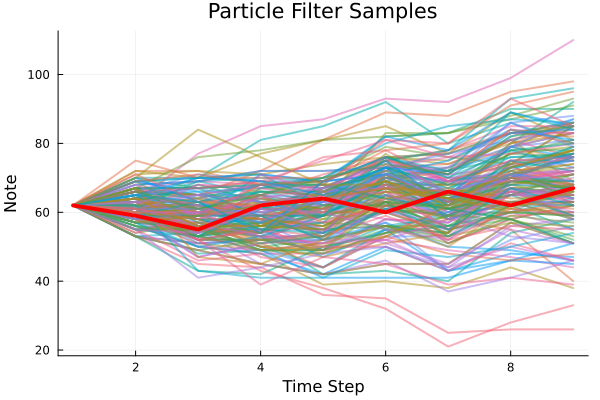

In [14]:
function visualize_samples(samples::Vector{Gen.DynamicDSLTrace}, obs_notes::Vector{Float64})
    plot()
    for trace in samples
        sequence = Vector(trace[:sequence])
        # Because of the way that melody works, it only logs the following notes after the first one, so I
        # added it back here
        pushfirst!(sequence, init_note)
        plot!(sequence, linewidth=2, alpha=0.5, legend=false)
    end
    plot!(obs_notes, linewidth=4, linecolor=:red, linestyle=:solid, label="Observed Sequence")
    xlabel!("Time Step")
    ylabel!("Note")
    title!("Particle Filter Samples")
    display(Plots.plot!())
end

init_note = 62.0
observed_notes = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0, 67.0]
visualize_samples(pf_traces, observed_notes)

In [15]:
last_notes = Float64[]
for trace in pf_traces
    last_note = trace[:sequence][end]
    push!(last_notes, last_note)
end

mu = mean(last_notes)

69.225

Seems pretty close to the actual last note! (67.0) Let's do this on all of the melodic stems to get a better picture of how the model performs.

### **Experiment: Model vs Human Performance in Melodic Expectation**

First, I'll need to read the data into a workable form.

In [16]:
# I had to make separate df's for different melody lengths, the code breaks otherwise
df6 = DataFrame(CSV.File("./data/stems6.csv"))
melodies6 = []
for col in names(df6)
    push!(melodies6, df6[!, col][1:7])
end
df6_keys = [D,C]
actual_means6 = Array(df6[7, :])

df7 = DataFrame(CSV.File("./data/stems7.csv"))
melodies7 = []
for col in names(df7)
    push!(melodies7, df7[!, col][1:8])
end
df7_keys = [E,E♭,D♭,B♭]
actual_means7 = Array(df7[8, :])

df8 = DataFrame(CSV.File("./data/stems8.csv"))
melodies8 = []
for col in names(df8)
    push!(melodies8, df8[!, col][1:9])
end
df8_keys = [G,B,E♭,E,B,F♯,E♭,E,D♭,A♭,C,G,F,E♭]
actual_means8 = Array(df8[9, :])

df9 = DataFrame(CSV.File("./data/stems9.csv"))
melodies9 = []
for col in names(df9)
    push!(melodies9, df9[!, col][1:9])
end
df9_keys = [F♯,A♭,B♭,F,C,G,D,A,A♭,B♭,F,D,A,B,F♯,E♭,F,D,E,B,F♯,D♭,A♭,B♭,F]
actual_means9 = Array(df9[9, :])

actual_means = vcat(actual_means6, actual_means7, actual_means8, actual_means9)

45-element Vector{Float64}:
 62.0
 60.0
 64.0
 63.0
 61.0
 63.0
 67.0
 59.0
 56.0
 64.0
 71.0
 66.0
 63.0
  ⋮
 58.0
 65.0
 58.0
 64.0
 64.0
 66.0
 57.0
 65.0
 63.0
 67.0
 57.0
 64.0

Here is where I run the particle filter on all of the melodies. In the end, I'll make a scatterplot and do a correlation test to see how well my model performed.

In [17]:
Random.seed!(704)

num_melodies = size(df6, 2)
model_means = []
for col_idx in 1:num_melodies
    melody_sequence = df6[!, col_idx][1:7]

    obs_notes = make_observations(melody_sequence[1:6], df6_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df6_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for col_idx in 1:num_melodies
    melody_sequence = df7[!, col_idx][1:8]

    obs_notes = make_observations(melody_sequence[1:7], df7_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df7_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df8, 2)
for col_idx in 1:num_melodies
    melody_sequence = df8[!, col_idx][1:9]

    obs_notes = make_observations(melody_sequence[1:8], df8_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df8_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for col_idx in 1:num_melodies
    melody_sequence = df9[!, col_idx][1:10]

    obs_notes = make_observations(melody_sequence[1:9], df9_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df9_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

### **Final results!**

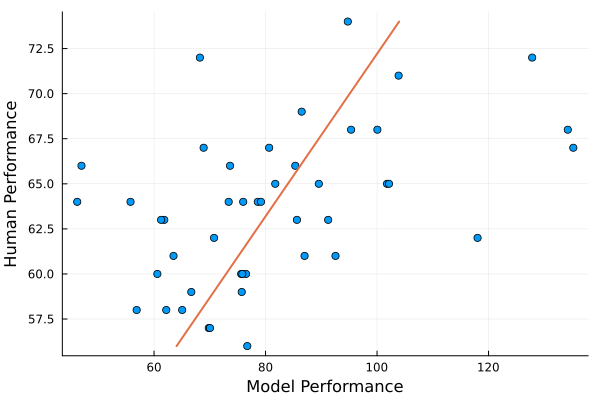

R value = 0.46189562826304154, R-squared value = 0.21334757140850957, p = 0.0014030553282060709


In [18]:
r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

### **Ablation**
How does the performance of the model change when I subset the physical forces?

#### **Subset with just magnetism and inertia, no gravity**

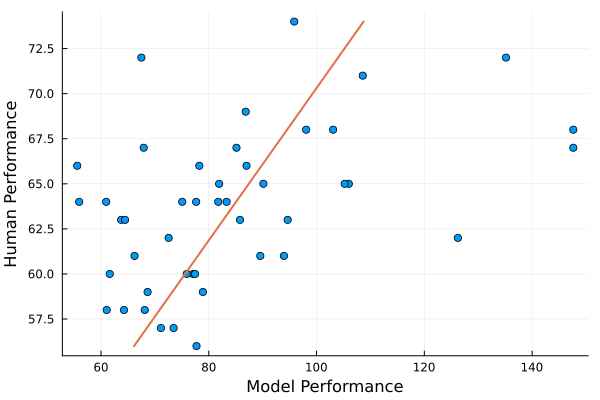

R value = 0.45980508703145967, R-squared value = 0.21142071806000817, p = 0.0014845081326882949


In [19]:
@gen function melody_kernel_no_grav(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.5
    w_g = 1
    w_m = 9
    w_i = 2
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    magnetism = @trace(normal(calculate_magnetism(curr_note, key), σ), :magnetism)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :inertia)

    #Add all forces together to get cumulative `F`
    force = w_m*magnetism + w_i*inertia

    #Apply force to find next note
    next_note = round(curr_note + force)

    return next_note
end 

chain = Gen.Unfold(melody_kernel_no_grav)
;

function particle_filter(num_particles::Int, num_samples::Int, key::MusicalScale, obs_notes, init_note)
    
    # Initial observations
    init_obs = Gen.choicemap(
        (:key, key),
        (:start, init_note)
    )

    # Initialize the particle filter
    state = Gen.initialize_particle_filter(melody, (0,), init_obs, num_particles)

    last_notes = Float64[]

    for (idx, obs_note) in enumerate(eachrow(obs_notes))
        # Evolve and resample
        Gen.maybe_resample!(state, ess_threshold=num_particles / 2)

        # Load observations of this time step
        obs = Gen.choicemap(
            (:sequence => idx => :obs_magnetism, obs_notes[idx, :magnetism]),
            (:sequence => idx => :inertia, obs_notes[idx, :inertia]),
        )

        # Re-weight by the likelihood
        Gen.particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end
    
    # Return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end
;

Random.seed!(704)

num_melodies = size(df6, 2)
model_means = []
for col_idx in 1:num_melodies
    melody_sequence = df6[!, col_idx][1:7]

    obs_notes = make_observations(melody_sequence[1:6], df6_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df6_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for col_idx in 1:num_melodies
    melody_sequence = df7[!, col_idx][1:8]

    obs_notes = make_observations(melody_sequence[1:7], df7_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df7_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df8, 2)
for col_idx in 1:num_melodies
    melody_sequence = df8[!, col_idx][1:9]

    obs_notes = make_observations(melody_sequence[1:8], df8_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df8_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for col_idx in 1:num_melodies
    melody_sequence = df9[!, col_idx][1:10]

    obs_notes = make_observations(melody_sequence[1:9], df9_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df9_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

#### **Subset with just gravity and inertia, no magnetism**

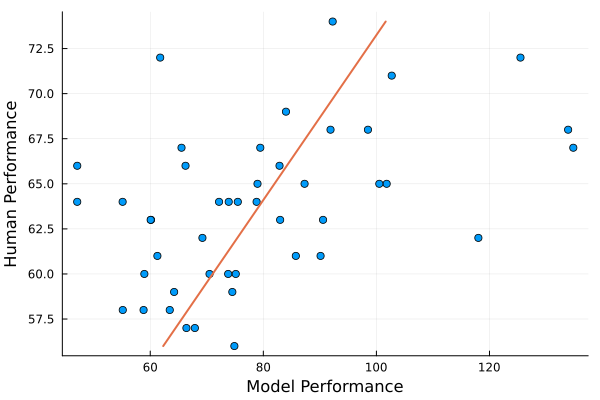

R value = 0.44896348876619435, R-squared value = 0.20156821424511284, p = 0.001978080745300967


In [20]:
@gen function melody_kernel_no_mag(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.5
    w_g = 1
    w_m = 9
    w_i = 2
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :gravity)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :inertia)

    #Add all forces together to get cumulative `F`
    force = w_g*gravity + w_i*inertia

    #Apply force to find next note
    next_note = round(curr_note + force)

    return next_note
end 

chain = Gen.Unfold(melody_kernel_no_mag)
;

function particle_filter(num_particles::Int, num_samples::Int, key::MusicalScale, obs_notes, init_note)
    
    # Initial observations
    init_obs = Gen.choicemap(
        (:key, key),
        (:start, init_note)
    )

    # Initialize the particle filter
    state = Gen.initialize_particle_filter(melody, (0,), init_obs, num_particles)

    last_notes = Float64[]

    for (idx, obs_note) in enumerate(eachrow(obs_notes))
        # Evolve and resample
        Gen.maybe_resample!(state, ess_threshold=num_particles / 2)

        # Load observations of this time step
        obs = Gen.choicemap(
            (:sequence => idx => :obs_gravity, obs_notes[idx, :gravity]),
            (:sequence => idx => :inertia, obs_notes[idx, :inertia]),
        )

        # Re-weight by the likelihood
        Gen.particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end
    
    # Return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end
;

Random.seed!(704)

num_melodies = size(df6, 2)
model_means = []
for col_idx in 1:num_melodies
    melody_sequence = df6[!, col_idx][1:7]

    obs_notes = make_observations(melody_sequence[1:6], df6_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df6_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for col_idx in 1:num_melodies
    melody_sequence = df7[!, col_idx][1:8]

    obs_notes = make_observations(melody_sequence[1:7], df7_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df7_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df8, 2)
for col_idx in 1:num_melodies
    melody_sequence = df8[!, col_idx][1:9]

    obs_notes = make_observations(melody_sequence[1:8], df8_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df8_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for col_idx in 1:num_melodies
    melody_sequence = df9[!, col_idx][1:10]

    obs_notes = make_observations(melody_sequence[1:9], df9_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df9_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

#### **Subset with just gravity and magnetism, no inertia**

In [ ]:
@gen function melody_kernel_no_in(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.5
    w_g = 1
    w_m = 9
    w_i = 2
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :gravity)
    magnetism = @trace(normal(calculate_magnetism(curr_note, key), σ), :magnetism)
    
    #Add all forces together to get cumulative `F`
    force = w_g*gravity + w_m*magnetism

    #Apply force to find next note
    next_note = round(curr_note + force)

    return next_note
end 

chain = Gen.Unfold(melody_kernel_no_in)
;

function particle_filter(num_particles::Int, num_samples::Int, key::MusicalScale, obs_notes, init_note)
    
    # Initial observations
    init_obs = Gen.choicemap(
        (:key, key),
        (:start, init_note)
    )

    # Initialize the particle filter
    state = Gen.initialize_particle_filter(melody, (0,), init_obs, num_particles)

    last_notes = Float64[]

    for (idx, obs_note) in enumerate(eachrow(obs_notes))
        # Evolve and resample
        Gen.maybe_resample!(state, ess_threshold=num_particles / 2)

        # Load observations of this time step
        obs = Gen.choicemap(
            (:sequence => idx => :obs_gravity, obs_notes[idx, :gravity]),
            (:sequence => idx => :inertia, obs_notes[idx, :inertia]),
        )

        # Re-weight by the likelihood
        Gen.particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end
    
    # Return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end
;

Random.seed!(704)

num_melodies = size(df6, 2)
model_means = []
for col_idx in 1:num_melodies
    melody_sequence = df6[!, col_idx][1:7]

    obs_notes = make_observations(melody_sequence[1:6], df6_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df6_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for col_idx in 1:num_melodies
    melody_sequence = df7[!, col_idx][1:8]

    obs_notes = make_observations(melody_sequence[1:7], df7_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df7_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df8, 2)
for col_idx in 1:num_melodies
    melody_sequence = df8[!, col_idx][1:9]

    obs_notes = make_observations(melody_sequence[1:8], df8_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df8_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for col_idx in 1:num_melodies
    melody_sequence = df9[!, col_idx][1:10]

    obs_notes = make_observations(melody_sequence[1:9], df9_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df9_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

### **More plots!**
I printed all of them so I could see which ones to possibly use in the report.

In [ ]:
Random.seed!(704)

num_melodies = size(df6, 2)
model_means = []
for col_idx in 1:num_melodies
    melody_sequence = df6[!, col_idx][1:7]

    obs_notes = make_observations(melody_sequence[1:6], df6_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df6_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    init_note = melody_sequence[1]
    visualize_samples(pf_traces, melody_sequence)
end

num_melodies = size(df7, 2)
for col_idx in 1:num_melodies
    melody_sequence = df7[!, col_idx][1:8]

    obs_notes = make_observations(melody_sequence[1:7], df7_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df7_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    init_note = melody_sequence[1]
    visualize_samples(pf_traces, melody_sequence)
end


num_melodies = size(df8, 2)
for col_idx in 1:num_melodies
    melody_sequence = df8[!, col_idx][1:9]

    obs_notes = make_observations(melody_sequence[1:8], df8_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df8_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end
    
    init_note = melody_sequence[1]
    visualize_samples(pf_traces, melody_sequence)
end


num_melodies = size(df9, 2)
for col_idx in 1:num_melodies
    melody_sequence = df9[!, col_idx][1:10]

    obs_notes = make_observations(melody_sequence[1:9], df9_keys[col_idx])
    pf_traces = particle_filter(2000, 200, df9_keys[col_idx], obs_notes, melody_sequence[1])

    last_notes = Float64[]
    for trace in pf_traces
        last_note = trace[:sequence][end]
        push!(last_notes, last_note)
    end

    init_note = melody_sequence[1]
    visualize_samples(pf_traces, melody_sequence)
end

### **References**
Larson, S. (2004). Musical Forces and Melodic Expectations: Comparing Computer Models and Experimental Results. Music Perception, 21(4), 457–498. https://doi.org/10.1525/mp.2004.21.4.457

Morgan, E., Fogel, A., Nair, A., & Patel, A. D. (2019). Statistical learning and Gestalt-like principles predict melodic expectations. Cognition, 189, 23–34. https://doi.org/10.1016/j.cognition.2018.12.015

Temperley, D. (2008). A Probabilistic Model of Melody Perception. Cognitive Science, 32(2), 418–444. https://doi.org/10.1080/03640210701864089
